# COMPUTER ASSIGNMENT 04


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## U-net for image segmentation

In class, we talked about U-net for image segmentation. This assignment is intended to 
- help you better understand the concept of U-net for image segmentation 
- help you get started with designing networks in pytorch including loading data, network design, loss function, training and testing.

For this assignment, you will attempt to segment car images, which is a challenge hosted on [Kaggle](https://www.kaggle.com/c/carvana-image-masking-challenge/data).  The original data is available on the Kaggle website. We have extracted a small part of the dataset and uploaded it to the following link 

https://drive.google.com/open?id=1gVSDa3eAJQ3DcSLVuQRYBgdxVhFvXEbR

You should create a folder 'data/' in the current folder.

Then download train, train_mask, test dataset from the above link and extract them to 'data/'.

Or you can download the whole dataset from [Kaggle website](https://www.kaggle.com/c/carvana-image-masking-challenge/data).

Let's first take a look at the images in the training dataset
<img src="00087a6bd4dc_01.jpg" width="200" height="200" />
 
 Each image in the training dataset has a corresponding mask
<img src="00087a6bd4dc_01_mask.gif" width="200" height="200" />


You should 
 -  Implement the U-net of the following architechure.
 ![U-net](UNet_Diagram.png)
 -  Write function dice_coeff(input, target) for evaluation
 -  Load training dataset and testing dataset.
 Notice that you should rescale the images to a smaller size (for example 80x100). Otherwise it takes too long to train on cpu.
 -  Train your network for a few epochs.
 -  Test your model by feeding in a new image in testing dataset. Plot your result.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
import glob
from tqdm import tqdm
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### [ TODO 1 ] First define following layers to be used later
- **Conv2d + BatchNorm2d + ReLu** as **single_conv layer** ,
- **down layer**: use **Maxpool2d** to downsample by a factor of 2
- **up layer**: takes two inputs of different dimensions. First use **nn.Upsample** to upsample the smaller input to be the same size as the larger, then **concatenate** the two along the channel dimension
-  **outconv layer**: **Conv2d** followed by **sigmoid activation** to generate probability for each pixel

You can check out the documentation in this link to understand how to use the methods called in the provided template:

 https://pytorch.org/docs/stable/nn.html


In [ ]:
################################################ [TODO] ###################################################
# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size = 3, stride = 1, padding = (1,1))
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # define forward operation using the layers we have defined
        x1 = self.conv(x)
        x2 = self.bn(x1)
        x = self.relu(x2)
        return x

################################################ [TODO] ###################################################
# DEFINE DOWN CLASS
class down(nn.Module):
    def __init__(self):
        super(down, self).__init__()
        self.down = nn.MaxPool2d(2,2) # use nn.MaxPool2d( )
        
    def forward(self, x):
        x = self.down(x)
        
        return x

################################################ [TODO] ###################################################
# DEFINE UP CLASS
# Note that this class will not only upsample x1, but also concatenate up-sampled x1 with x2 to generate the final output

class up(nn.Module):
    def __init__(self):
        super(up, self).__init__()       
        self.up = nn.Upsample(scale_factor= 2 , mode = 'bilinear', align_corners = True)  # use nn.Upsample() with mode bilinear

    def forward(self, x1, x2): # Takes in smaller x1 and larger x2
        # First we upsample x1 to be same size as x2
        x1 = self.up(x1)

        # This part is tricky so we've completed this
        # Notice that x2 and x1 may not have the same spatial size. 
        # This is because when you downsample old_x2(say 25 by 25), you will get x1(12 by 12)   
        # Then you perform upsample to x1, you will get new_x1(24 by 24)
        # You should pad a new row and column so that new_x1 and x2 have the same size.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # Now we concatenat x2 and x1 along channel dimension: torch.cat()
        # Note pytorch tensor shape correspond to: (batchsize, channel, x_dim, y_dim)
        x = torch.cat([x1,x2],1)
        return x

################################################ [TODO] ###################################################
# DEFINE OUTCONV CLASS
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size = 3, stride = 1, padding = (1,1))

    def forward(self, x):
        x = self.conv(x)
        # Apply sigmoid activation: torch.sigmoid()
        x = torch.sigmoid(x)
        return x
    

In [ ]:
################################################ [TODO] ###################################################
# Build your network with predefined classes: single_conv, up, down, outconv
# The number of input and output channels should follow the U-Net Structure shown above.
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels_in, n_channels_out):
        super(UNet, self).__init__()
        ## Define the necessary layers using the classes defined above
        self.c1 = single_conv(n_channels_in,16)
        self.d1 = down()
        self.c2 = single_conv(16,32)
        self.d2 = down()
        self.c3 = single_conv(32,32)

        self.u1 = up()
        self.c4 = single_conv(64,16)
        self.u2 = up()
        self.c5 = single_conv(32,16)

        self.cout = outconv(16,n_channels_out)

    def forward(self, x):
        # Define forward pass
        conv1 = self.c1(x)
        down1 = self.d1(conv1)
        conv2 = self.c2(down1)
        down2 = self.d2(conv2)
        conv3 = self.c3(down2)
        up1 = self.u1(conv3,conv2)
        conv4 = self.c4(up1)
        up2 = self.u2(conv4,conv1)
        conv5 = self.c5(up2)
        x = self.cout(conv5)
             
        return x

### [ TODO 2 ] Define evaulation function:
Dice coefficient is defined as 
![dice.png](dice.png)
For the case of evaluating a Dice coefficient on predicted segmentation masks, we can approximate intersection of A and B as the element-wise multiplication between the prediction and target mask, and then sum the resulting matrix.

In order to quantify the area of A union B, some researchers use the simple sum whereas other researchers prefer to use the squared sum for this calculation. You can use either way.



In [ ]:
################################################ [TODO] ###################################################
# define dice coefficient 
class DiceCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, prediction, target):
        self.save_for_backward(prediction, target)
        eps = 0.0001 # in case union = 0
        ################################################ [TODO] ###################################################
        # Calculate intersection and union. 
        # You can convert a tensor into a vector with tensor.contiguous().view(-1)
        # Then use torch.dot(A, B) to calculate the intersection.
        A = prediction.contiguous().view(-1)
        B = target.contiguous().view(-1)
        self.inter = torch.dot(A,B).sum()
        self.union = A.sum() + B.sum() + eps
        # Calculate DICE 
        d = self.inter / self.union
        return d


################################################ [TODO] ###################################################
# Calculate dice coefficients for batches
def dice_coeff(prediction, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()
    
    # For each pair of input and target, call DiceCoeff().forward(prediction, target) to calculate dice coefficient
    # Then calculate average over all pairs
    for i, (a,b) in enumerate(zip(prediction, target)):
        s = DiceCoeff().forward(a, b)
    s = s / (i + 1)
    return s


### Load images and masks

Load training imagse, normalize and resize them into smaller size so that you can perform training using a CPU. Split them into training and validation. Validation percent of 0.05 means 5% of training dataset is used as validation. In order to avoid repeated data preprocessing, we use the pickle tool to save the processed data.

This part has been done for you. But please read through so that you learn the general processing steps.

In [ ]:
# try to split the whole train dataset into train and validation, and match the train image path with the 
# corresponding label path
def split_train_val(image_paths, mask_paths, train_size):
    img_paths_dic = {}
    mask_paths_dic = {}
    len_data = len(image_paths)
    print('total len:', len_data)
    for i in range(len(image_paths)):
        img_paths_dic[os.path.basename(image_paths[i])[:-4]] = image_paths[i]

    for i in range(len(mask_paths)):
        mask_paths_dic[os.path.basename(mask_paths[i])[:-9]] = mask_paths[i]
        
    img_mask_list = []
    for key in img_paths_dic:
        img_mask_list.append((img_paths_dic[key], mask_paths_dic[key]))
        
    train_img_mask_paths = img_mask_list[:int(len_data*train_size)] 
    val_img_mask_paths = img_mask_list[int(len_data*train_size):]
    return train_img_mask_paths, val_img_mask_paths

# read in the image and label pair, and then resize them from 1280*1918 to 80*100 by consideration of 
# your computer memory limitation
def preprocess_image(image_mask_paths):
    img_mask_list = []
    new_h, new_w = 80, 100
    
    for i in tqdm(range(len(image_mask_paths))):
        # cv2 cannot read .gif files
        # Use Image.open() to open image and mask, then convert them to np arrays
        # For images use float32, mask use uint8
        # Normalize img to range (0,1)
        img = np.array(Image.open(image_mask_paths[i][0]), np.float32) / 255.0 
        mask = np.array(Image.open(image_mask_paths[i][1]), np.uint8)
        
        # Use cv2 to resize images to 80x100, use INTER_CUBIC interpolation
        img_resize = cv2.resize(img, dsize=(new_w, new_h), interpolation=cv2.INTER_CUBIC)
        mask_resize = np.uint8(cv2.resize(mask, dsize=(new_w, new_h), interpolation=cv2.INTER_CUBIC))
        
        img_mask_list.append((img_resize, mask_resize))
    return img_mask_list

# save the data into pickle file and you can just reload this file, which can help you avoid reading the image
# file again in the future, since reading in image file from hard drive would take quite a long time
def pickle_store(file_name,save_data):
    fileObj = open(file_name,'wb')
    pickle.dump(save_data,fileObj)
    fileObj.close()

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/Colab Notebooks/Image and Video processing/Computer Assignment 4/data/data.zip','r') as zipObj:
  zipObj.extractall('data')

In [ ]:
# get all the image and mask path and number of images
image_paths = glob.glob("data/train/*.jpg")
mask_paths = glob.glob("data/train_masks/*.gif")

# split these path using a certain percentage
train_size = 0.95
print('original image shape: {}'.format(np.array(Image.open(image_paths[0])).shape))
print('orginal mask shape: {}'.format(np.array(Image.open(mask_paths[0])).shape))

train_img_mask_paths, val_img_mask_paths = split_train_val(image_paths, mask_paths, train_size)

print('train len: {}, val len: {}'.format(len(train_img_mask_paths),len(val_img_mask_paths)))

original image shape: (1280, 1918, 3)
orginal mask shape: (1280, 1918)
total len: 5088
train len: 4833, val len: 255


In [ ]:
## This part preprocess the images and save them to pickle files.
## If the pickle file already exists, this part will not run
## IMPORTANT: If you made any change to the prepreprocess function, 
## you need to delete the pickle files before you rerun this part
train_img_masks_save_path = './data/train_img_masks.pickle'
if os.path.exists(train_img_masks_save_path):
    with open(train_img_masks_save_path,'rb') as f:
        train_img_masks = pickle.load(f)
    f.close()
else:
    train_img_masks = preprocess_image(train_img_mask_paths)
    pickle_store(train_img_masks_save_path,train_img_masks)
print('train len: {}'.format(len(train_img_masks)))

train len: 4833


In [ ]:
val_img_masks_save_path = './data/val_img_masks.pickle'
if os.path.exists(val_img_masks_save_path):
    with open(val_img_masks_save_path,'rb') as f:
        val_img_masks = pickle.load(f)
    f.close()
else:
    val_img_masks = preprocess_image(val_img_mask_paths)
    pickle_store(val_img_masks_save_path,val_img_masks)
print('val len: {}'.format(len(val_img_masks)))

val len: 255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


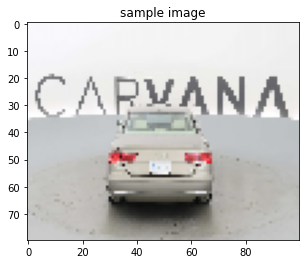

In [ ]:
#### Let us display some of the images to make sure the data loading and processing is correct.
### the original size of the image is: 1280*1918, but we resize the image to 80*100 for 
### training the segmentation network
img_num = 9
plt.imshow(train_img_masks[img_num][0])
plt.title("sample image")
plt.show()

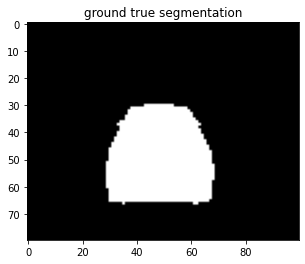

In [ ]:
plt.imshow(train_img_masks[img_num][1], cmap='gray')
plt.title("ground true segmentation")
plt.show()

### Create datasets in the format that you can later use Torch  "DataLoader" during training and define  data augmentation 

In [ ]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [ ]:
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 

        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = self.image_masks[index][0] # H, W, C
        mask = self.image_masks[index][1]
        
        image = np.transpose(image, axes=[2, 0, 1]) # C, H, W
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))

### [ TODO 3 ] Start training your network

In [ ]:
################################################ [TODO] ###################################################
# This function is used to evaluate the network after each epoch of training
# Input: network and validation dataset
# Output: average dice_coeff
def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    for i, b in enumerate(dataset):
        img = b['img'].to(device)
        B = img.shape[1]
        true_masks = b['label'].to(device)
        ################################################ [TODO] ################################################### 
        # Feed the image to network to get predicted mask
        net = UNet(B,1)
        net.to(device)
        masks_pred = net(img)
        
        # For all pixels in predicted mask, set them to 1 if larger than 0.5. Otherwise set them to 0
        masks_pred.masked_fill_(masks_pred>0.5 , 1)
        masks_pred.masked_fill_(masks_pred<0.5 , 0)
        # calculate dice_coeff()
        # note that you should add all the dice_coeff in validation/testing dataset together 
        # call dice_coeff() here
        tot += dice_coeff(masks_pred, true_masks)
        # Return average dice_coeff()
    return tot / (i + 1)

In [ ]:
################################################ [TODO] ###################################################
# Create a UNET object from the class defined above. Input channels = 3, output channels = 1
net = UNet(3,1)
# run net.to(device) if using GPU
net.to(device)
# If continuing from previously saved model, use 
# net.load_state_dict(torch.load('PATH TO SAVED MODEL FILE'))
print(net)

# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

UNet(
  (c1): single_conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (d1): down(
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c2): single_conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (d2): down(
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c3): single_conv(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (u1): up(
    (up): Upsample(scale_factor=2.0, mode=bilinear)
  )
  (c4): single_conv(
    (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
################################################ [TODO] ###################################################
# Specify number of epochs, image scale factor, batch size and learning rate
epochs = 12      # e.g. 10, or more until dice converge
batch_size = 16    # e.g. 16
lr = 0.01            # e.g. 0.01
N_train = len(train_img_masks)
model_save_path = './model/'  # directory to same the model after each epoch. 

################################################ [TODO] ###################################################
# Define an optimizer for your model.
# Pytorch has built-in package called optim. Most commonly used methods are already supported.
# Here we use stochastic gradient descent to optimize
# For usage of SGD, you can read https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html
# Also you can use ADAM as the optimizer
# For usage of ADAM, you can read https://www.programcreek.com/python/example/92667/torch.optim.Adam

optimizer = torch.optim.SGD(net.parameters(),lr = 0.0005, momentum = 0.9, weight_decay=0.0005 )
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

# The loss function we use is binary cross entropy: nn.BCELoss()
criterion = nn.BCELoss()
# note that although we want to use DICE for evaluation, we use BCELoss for training in this example

################################################ [TODO] ###################################################
# Start training  #This part takes very long time to run if using CPU
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    for i, b in enumerate(train_loader):
        ################################################ [TODO] ###################################################
        # Get images and masks from each batch
        
        imgs = b['img'].to(device)
        true_masks = b['label'].to(device)
        ################################################ [TODO] ###################################################
        # Feed your images into the network
        masks_pred = net(imgs)
        masks_pred = nn.functional.interpolate(masks_pred, size=(80,100), mode='bilinear')
        # Flatten the predicted masks and true masks. For example, A_flat = A.view(-1)
        masks_probs_flat = masks_pred.contiguous().view(-1)
        true_masks_flat = true_masks.contiguous().view(-1)
        ################################################ [TODO] ###################################################
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = criterion(masks_probs_flat,true_masks_flat) 
        epoch_loss += loss.item()
        if count % 20 == 0:  #Print status every 20 batch
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item())) 
        count = count + 1
        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. 
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. 
        # These are accumulated into x.grad for every parameter x
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad. 
        optimizer.step()
        
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    ################################################ [TODO] ###################################################
    # Perform validation with eval_net() on the validation data
    val_dice = eval_net(net , val_loader)
    print('Validation Dice Coeff: {}'.format(val_dice))
    
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

    

Starting epoch 1/12.
0.0000 --- loss: 0.674609


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.0662 --- loss: 0.553937
0.1324 --- loss: 0.457801
0.1986 --- loss: 0.393810
0.2648 --- loss: 0.331712
0.3311 --- loss: 0.289180
0.3973 --- loss: 0.247625
0.4635 --- loss: 0.222371
0.5297 --- loss: 0.201335
0.5959 --- loss: 0.186046
0.6621 --- loss: 0.175511
0.7283 --- loss: 0.168192
0.7945 --- loss: 0.162156
0.8607 --- loss: 0.163500
0.9270 --- loss: 0.140974
0.9932 --- loss: 0.135135
Epoch finished ! Loss: 0.27282272113968203
Validation Dice Coeff: 0.008538654074072838
Checkpoint 1 saved !
Starting epoch 2/12.
0.0000 --- loss: 0.125405
0.0662 --- loss: 0.108621
0.1324 --- loss: 0.124859
0.1986 --- loss: 0.114725
0.2648 --- loss: 0.121478
0.3311 --- loss: 0.100980
0.3973 --- loss: 0.108700
0.4635 --- loss: 0.107835
0.5297 --- loss: 0.100942
0.5959 --- loss: 0.085880
0.6621 --- loss: 0.102887
0.7283 --- loss: 0.086314
0.7945 --- loss: 0.086890
0.8607 --- loss: 0.080321
0.9270 --- loss: 0.093462
0.9932 --- loss: 0.086126
Epoch finished ! Loss: 0.10338557785413913
Validation Dice Coeff:

### [ TODO 4 ] load one image from testing dataset and plot output mask

In [ ]:
################################################ [TODO] ###################################################
# Define a function for prediction/testing
def predict_img(net,full_img,out_threshold=0.5):
    # set the mode of your network to evaluation
    net.eval()

    #print('Before Transpose:',full_img.shape)
# convert from Height*Width*Channel TO Channel*Height*Width
    full_img = np.transpose(full_img , (2,0,1))
    
# convert numpy array to torch tensor, normalize to range (0,1)

    X_img = torch.Tensor(full_img)
    #print('Tensor:',X_img.shape)
    X_img = X_img.to(device)
    X_img = X_img.unsqueeze(0)
    X_img = X_img/255
    X_img = X_img.float()
    #print('X_img :',X_img.shape)
    

    with torch.no_grad():
        ################################################ [TODO] ###################################################
        # predict the masks
        
        print(X_img.type)
        net.to(device)
        output_img = net(X_img)
        
        out_probs = output_img.squeeze(0).squeeze(0)
        # threshold the probability to generate mask: mask=1 if prob > out_threshold
        out_probs.masked_fill_(out_probs > out_threshold,1)
        out_probs.masked_fill_(out_probs < out_threshold,0)
       
        # change back to numpy, set to uint8 
        out_mask_np = out_probs.cpu().numpy()
        out_mask_np = np.array(out_mask_np , dtype = np.uint8)
        
    return out_mask_np


In [ ]:
################################################ [TODO] ###################################################
# Load an image from testing dataset
test_imgs_paths = glob.glob("data/test/*.jpg")

# Generating a list
test_imgs = []

for test_imgs_paths in glob.glob("data/test/*.jpg"):
  n = cv2.imread(test_imgs_paths)
  test_imgs.append(n)



<built-in method type of Tensor object at 0x7ff1252118b8>
(100, 80)


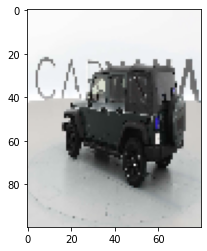

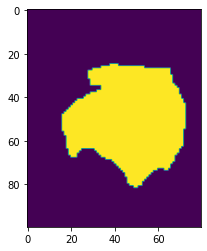

In [ ]:
################################################ [TODO] ###################################################
# Predict the mask
img_resize = cv2.resize(test_imgs[6], dsize=(80, 100), interpolation=cv2.INTER_CUBIC)
plt.figure()
plt.imshow(img_resize)

mask = predict_img(net, img_resize, out_threshold=0.5)
# Rescale the mask back to original image size
mask =  cv2.resize(mask, dsize=(80,100), interpolation=cv2.INTER_CUBIC)
plt.figure()
plt.imshow(mask)
print(mask.shape)
img_resize1 = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)



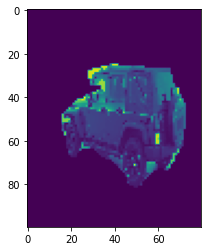

In [ ]:
## Extract the car from the image using the predicted mask
img_seg = img_resize1 * mask
plt.figure()
plt.imshow(img_seg)

### Plot original image and mask image

Text(0.5, 1.0, 'Car')

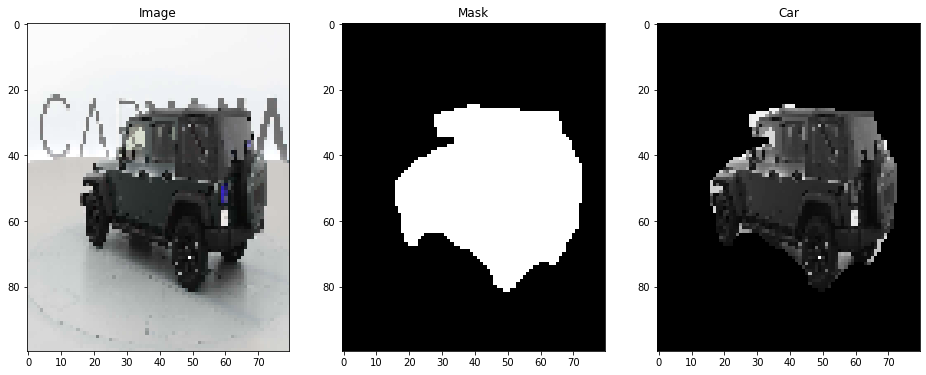

In [ ]:
################################################ [TODO] ###################################################
# Plot original images and masks and segmented part
plt.figure(figsize = (16,48))
plt.subplot(1,3,1)
plt.imshow(img_resize,cmap = 'gray')
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(mask,cmap = 'gray')
plt.title('Mask')
plt.subplot(1,3,3)
plt.imshow(img_seg ,cmap = 'gray')
plt.title('Car')

<built-in method type of Tensor object at 0x7ff125326ea0>
<built-in method type of Tensor object at 0x7fece4664c18>
<built-in method type of Tensor object at 0x7fece217c510>
<built-in method type of Tensor object at 0x7fece2112e10>
<built-in method type of Tensor object at 0x7fece20a8708>
<built-in method type of Tensor object at 0x7fecdbfa0f78>
<built-in method type of Tensor object at 0x7fecdbecb900>
<built-in method type of Tensor object at 0x7ff125352798>
<built-in method type of Tensor object at 0x7ff18465c870>
<built-in method type of Tensor object at 0x7ff1252c7ea0>


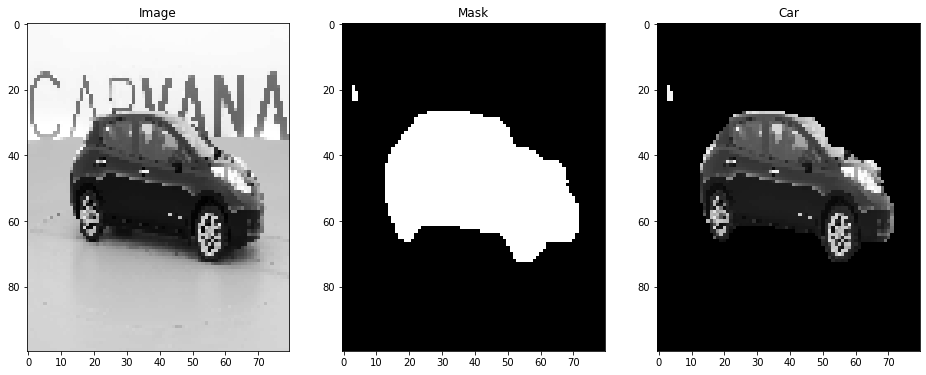

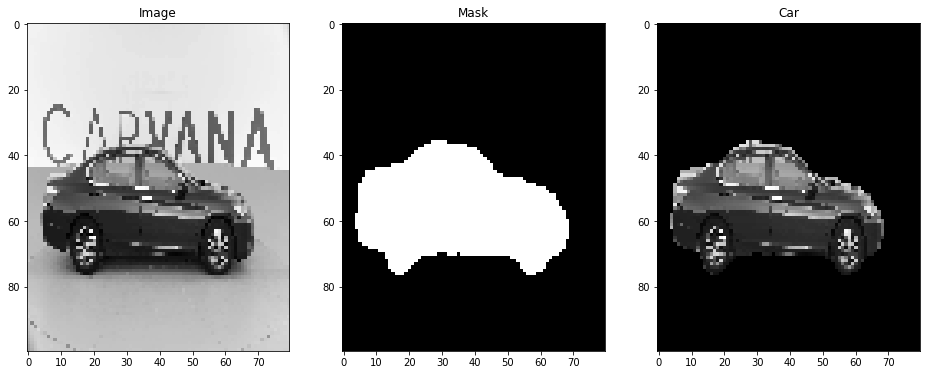

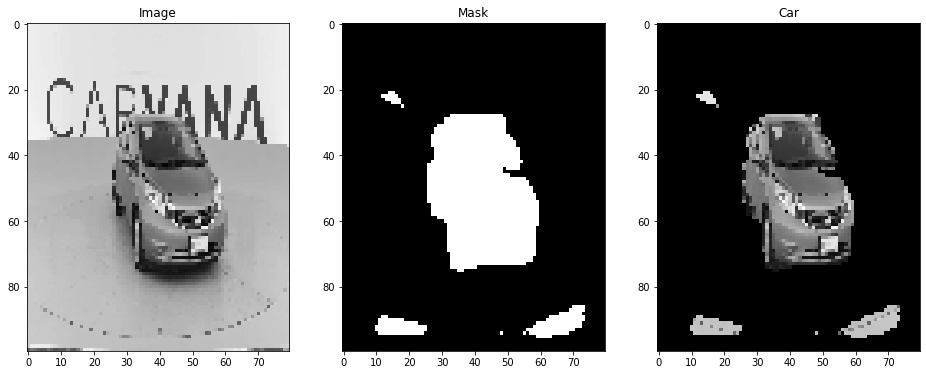

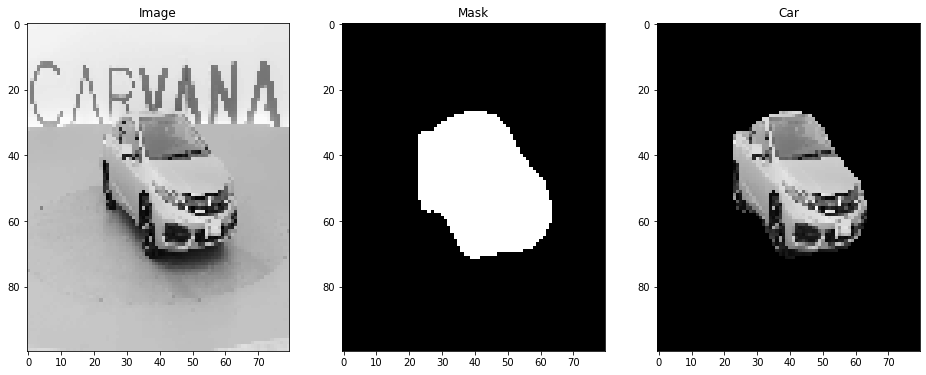

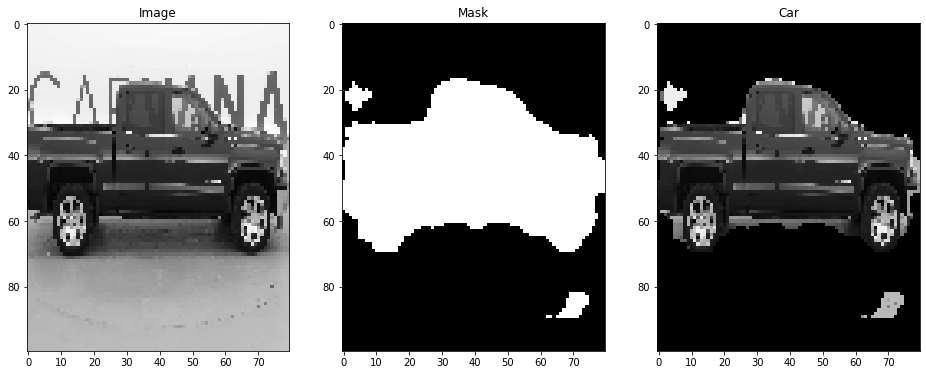

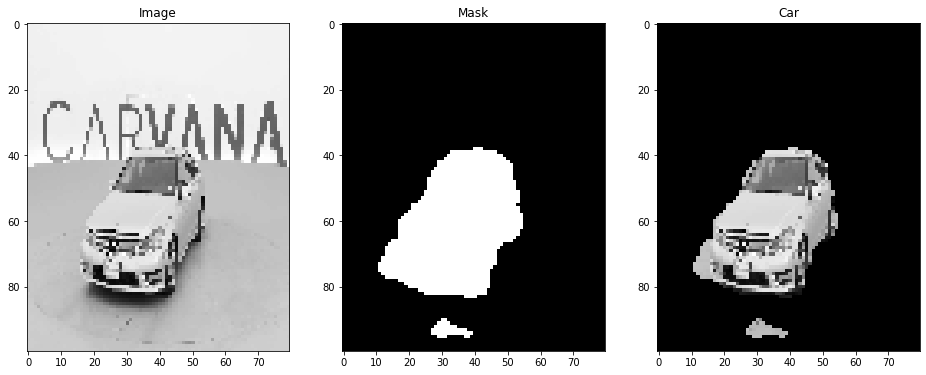

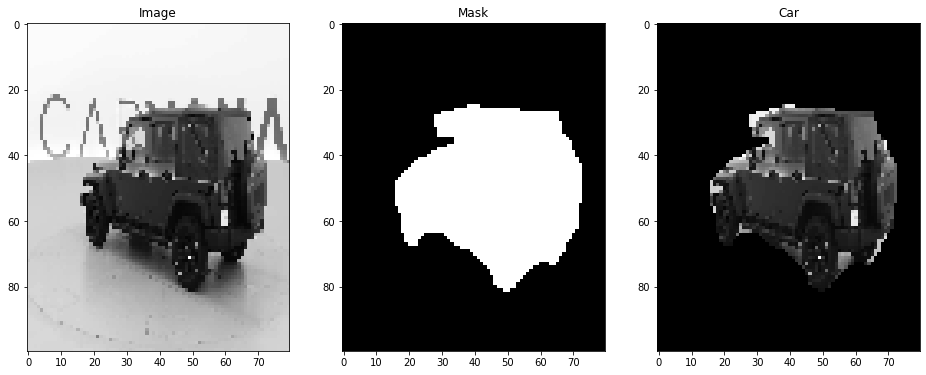

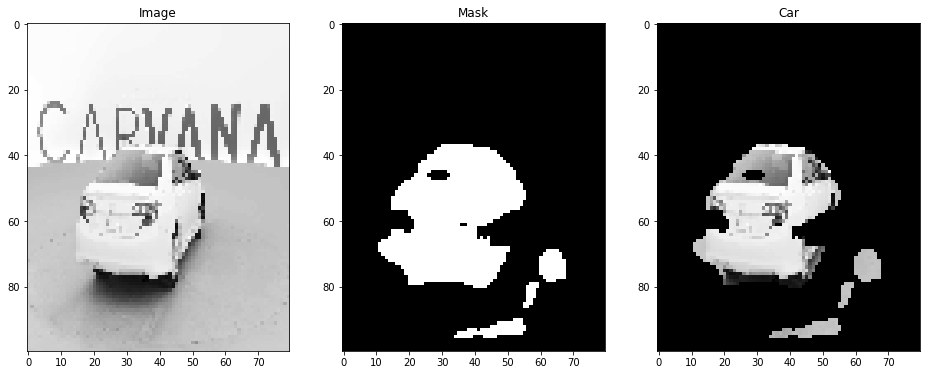

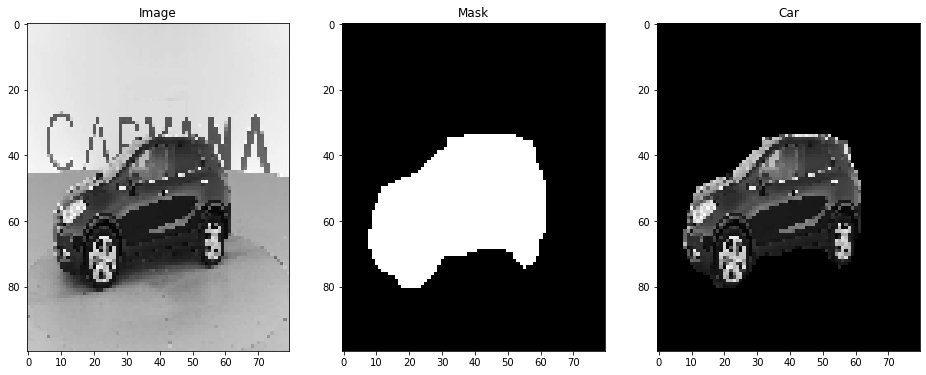

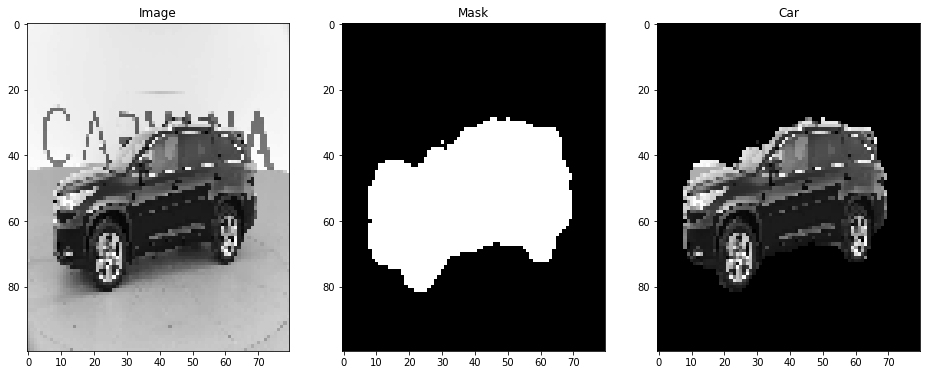

In [ ]:
################################################ [TODO] ###################################################
# Display ten more of test samples
from random import randint

for i in range(10):
  #b = random.randint(1, len(test_imgs_paths))
  imgs = test_imgs[i]

  # Resize image to (80,100)
  img_resize = cv2.resize(imgs, dsize=(80, 100), interpolation=cv2.INTER_CUBIC)
  
  # Predict the mask
  mask = predict_img( net, img_resize, out_threshold=0.5)
  # Rescale the mask back to original image size
  mask =  cv2.resize(mask, dsize=(80,100), interpolation=cv2.INTER_CUBIC)
  test_imgs1 = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
  img_seg = test_imgs1 * mask
  plt.figure(figsize = (16,48))
  plt.subplot(1,3,1)
  plt.imshow(test_imgs1,cmap = 'gray')
  plt.title('Image')
  plt.subplot(1,3,2)
  plt.imshow(mask,cmap = 'gray')
  plt.title('Mask')
  plt.subplot(1,3,3)
  plt.imshow(img_seg,cmap = 'gray')
  plt.title('Car')


# RAM KEEPS CRASHING FOR THIS ONE


In [ ]:
#